In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time, timedelta


In [500]:
# My Project is structured as follows:
# General Data Analysis, reasoning and key functions
# Question 1 : A Z-Score Trading Algorithm
# Analysis for Question 2
# Question 2 : A Bollinger Bands Trading Algorithm
# Question 3 : Comparison of the models
# Assumptions and Summary

In [501]:
df1 = pd.read_parquet('data.parquet', engine='pyarrow')

In [502]:
df = df1.between_time('09:15', '15:30').fillna(method='ffill')  # Filter out market hours and fill missing values

In [503]:
# We first create a simple z score function to calculate all rolling Z-Scores of a given time series.
def z_scores(spread, window = 20):  #Window of 20 is a good balance between lag and sensitivity. 
    
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    return (spread - rolling_mean) / rolling_std

In [504]:
# Create some new columns in our dataframe, for plotting purposes.
df['Spread'] = df['banknifty'] - df['nifty']
df['Z Scores'] = z_scores(df['Spread'], window = 20)

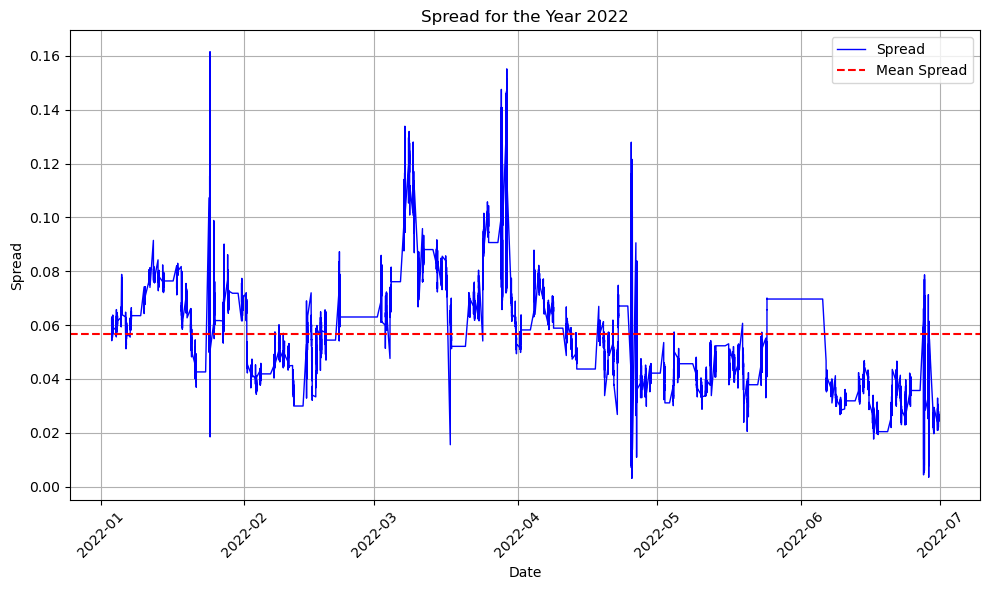

In [505]:
# General Idea for why pairs trading works, let us plot the spread against time for the first 6 months of 2022.

start_date = '2022-01-01'
end_date = '2022-06-30'
df_filtered = df.loc[start_date:end_date]

mean_spread = df_filtered['Spread'].mean()

# Plotting
plt.figure(figsize=(10, 6))  
plt.plot(df_filtered.index, df_filtered['Spread'], label='Spread', color='blue', linewidth=1)
plt.axhline(mean_spread, color='red', linestyle='--', label='Mean Spread')
plt.title('Spread for the Year 2022') 
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()

In [506]:
# This plot shows us the variation of the spread. It fluctuates constantly around the mean.
# As can be witnessed from the graph, the spread always returns to its mean value, in support of the thesis.

In [507]:
# Later we will need this function for computing sharpe ratios and drawdown. 
# It changes a daily pnl time series dictionary into percentage daily returns for a given initial investment.
# (We need starting cash so that the percentage returns aren't unbounded, since some days we make no money)

def daily_pnl_to_returns(daily_pnl, initial_investment):

    # Convert daily P&L dictionary to a series
    daily_pnl_series = pd.Series(daily_pnl)
    
    # Calculate cumulative P&L
    cumulative_pnl = daily_pnl_series.cumsum()
    
    # Calculate daily portfolio value by adding cumulative P&L to the initial investment
    daily_portfolio_value = cumulative_pnl + initial_investment
    
    # Calculate daily returns as percentage change in portfolio value
    daily_returns = daily_portfolio_value.pct_change().fillna(0)
    
    return daily_returns

In [508]:
# Question 1: The Z Score trading algorithm.


def z_score_trade_costs(BN, N, T):
    
    spread = BN - N
    zscore = z_scores(spread)
    
    p_l = 0                            # Overall P/L
    spread_at_trade = 0                # Records the spread when we make a trade.
    number_of_longs = 0                # Tracks how many times we go long on the spread
    is_long = False                    # Tracks if we are long on the spread
    number_of_shorts = 0               # Tracks how many times we go short on the spread
    is_short = False                   # Tracks if we are short on the spread
    no_of_liquidations =0              # Tracks the number of times we liquidate a trade (buy it back or sell it)
    trade_time = None                  # Records the time at which we go long/short
    minute_p_l = {}                    # Tracks minutely p/l, used for sharpe ratio
    
    for i in range(len(spread)):
        current_datetime = spread.index[i]       # Current date and time of our row
        current_time = current_datetime.time()   # Extract the time part of the datetime index
        current_day = current_datetime.date()    # Extract the day of our datetime index
        
        if current_day not in minute_p_l:        # For sharpe ratio, completeness of dictionary
            minute_p_l[current_day] = 0           
        
        # First Signal : If Z-Score > 1.75, we want to short the spread (Sell Bank Nifty, Buy Nifty).
        # I will discuss the reasoning for these Z-Scores at the end under 'Assumptions'.
        
        
        if zscore[i] > 1.75 :
            if (not is_long and not is_short) :                     # Only Trade if we have no positions
                    spread_at_trade = spread[i]                     # Record what our spread is at this time
                    number_of_shorts += 1                           # We go short one time
                    is_short = True                                 # Now short on the spread
                    trade_time = spread.index[i]                    # Record the datetime of the trade
                
       
        # Second Signal : If Z-Score < -1.75, we want to go long on the spread (Buy Bank Nifty, Sell Nifty)
        
        elif zscore[i] < -1.75 :
            if (not is_long and not is_short):      # Now do the opposite of above
                    spread_at_trade = spread[i]  
                    number_of_longs += 1
                    is_long = True
                    trade_time = spread.index[i]
        
                
        # Now we create exit signals
        # We check if we are allowed to exit, i.e. we need to be in the medium frequency trading zone.
        
        if trade_time is not None:
            time_since_trade = current_datetime - trade_time                   # Allows us to check how long our position is held
        
            if timedelta(minutes=30) <= time_since_trade < timedelta(days=5):  # Medium Frequency Trading
        
                if abs(zscore[i]) < 0.75 :          # Exit point is between -0.75 and 0.75
                    if is_long or is_short:
                        # Calculate P/L based on whether we're long or short
                        
                        # Our profit is always sell 'price' - buy 'price'
                        # If we were long/short on the spread, our profit is (spread when we sell - spread when we buy) * (tte**0.7) 
                        
                        profit_loss = (spread[i] - spread_at_trade) * (T[i]**0.7) if is_long else (spread_at_trade - spread[i]) * (T[i]**0.7)
                        p_l += 0.99 * profit_loss     
                        minute_p_l[current_day] += profit_loss    # Update our daily pnl
                        spread_at_trade = 0
                        no_of_liquidations += 1
                        is_long = False
                        is_short = False
                        trade_time = None    # Resets our variables so we can trade again
        
            
            # If we still have a position at T = 5 days from the trade, then liquidate
            if time_since_trade >= timedelta(days=5) and (is_long or is_short):
                
                # Calculate P/L for either long or short positions
                
                profit_loss = (spread[i] - spread_at_trade) * (T[i]**0.7) if is_long else (spread_at_trade - spread[i]) * (T[i]**0.7)
                p_l += 0.99 * (profit_loss)
                minute_p_l[current_day] += profit_loss
                spread_at_trade = 0
                no_of_liquidations += 1
                is_long = False
                is_short = False
                trade_time = None
                
    # Now convert minutely pnl to daily pnl using resampling
    
    df = pd.DataFrame(list(minute_p_l.items()), columns=['DateTime', 'PnL'])

    # Convert the 'DateTime' column to datetime type
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Set the 'DateTime' column as the index
    df.set_index('DateTime', inplace=True)

    # Resample to daily frequency and sum up the P&L for each day
    daily_pnl = df.resample('D').sum()

    # Convert back to dictionary
    daily_p_l = daily_pnl['PnL'].to_dict()

    
    
    daily_returns = daily_pnl_to_returns(daily_p_l, 100)  # Uses earlier formula to calculate daily returns, 100 initial cash.
    
                
                
                    
    return [p_l, number_of_longs , number_of_shorts , no_of_liquidations, daily_returns]


In [509]:
z_score_model = z_score_trade_costs(df['banknifty'], df['nifty'], df['tte']) # Create Variable for our data

In [485]:
# My idea for Question 2 is to use Bollinger Bands as trading signals. Again, we will work with the spread of
# the data. Before building the model, let us plot a graph as in question 1 to visually analyse
# what these Bollinger Bands are, and when we would potentially make trades based off of them.

# We will pick a random trading day to do this, so the graph is clearer to see since our time series is minutely.

In [510]:
# Make the columns
window = 20
k = 2

# Middle Band (Rolling Mean)
df['middle_band'] = df['Spread'].rolling(window=window).mean()

# Standard Deviation
df['std_dev'] = df['Spread'].rolling(window=window).std()

# Upper Band
df['upper_band'] = df['middle_band'] + (df['std_dev'] * k)

# Lower Band
df['lower_band'] = df['middle_band'] - (df['std_dev'] * k)

# Long Entry Points
df['long_entry'] = df['Spread'] < df['lower_band']

# Short Entry Points
df['short_entry'] = df['Spread'] > df['upper_band']

# Now plot these columns
def plot_bollinger_bands(df, start_date, end_date):
   
    
    filtered_df = df.loc[start_date:end_date]

    plt.figure(figsize=(14, 7))

    # Plot Spread and Bollinger Bands
    plt.plot(filtered_df.index, filtered_df['Spread'], label='Spread', color='blue')
    plt.plot(filtered_df.index, filtered_df['middle_band'], label='Rolling Mean', color='black', linestyle='--')
    plt.plot(filtered_df.index, filtered_df['upper_band'], label='Upper Band', color='red', linestyle='--')
    plt.plot(filtered_df.index, filtered_df['lower_band'], label='Lower Band', color='green', linestyle='--')
    
    # Long Entry Points marked with blue crosses
    buy_entries = filtered_df[filtered_df['long_entry']]
    plt.scatter(buy_entries.index, buy_entries['Spread'], color='blue', label='Buy Entry', marker='x', s=100)
    
    # Short Entry Points marked with red crosses
    short_entries = filtered_df[filtered_df['short_entry']]
    plt.scatter(short_entries.index, short_entries['Spread'], color='red', label='Short Entry', marker='x', s=100)


    plt.title(f'Spread and Bollinger Bands from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

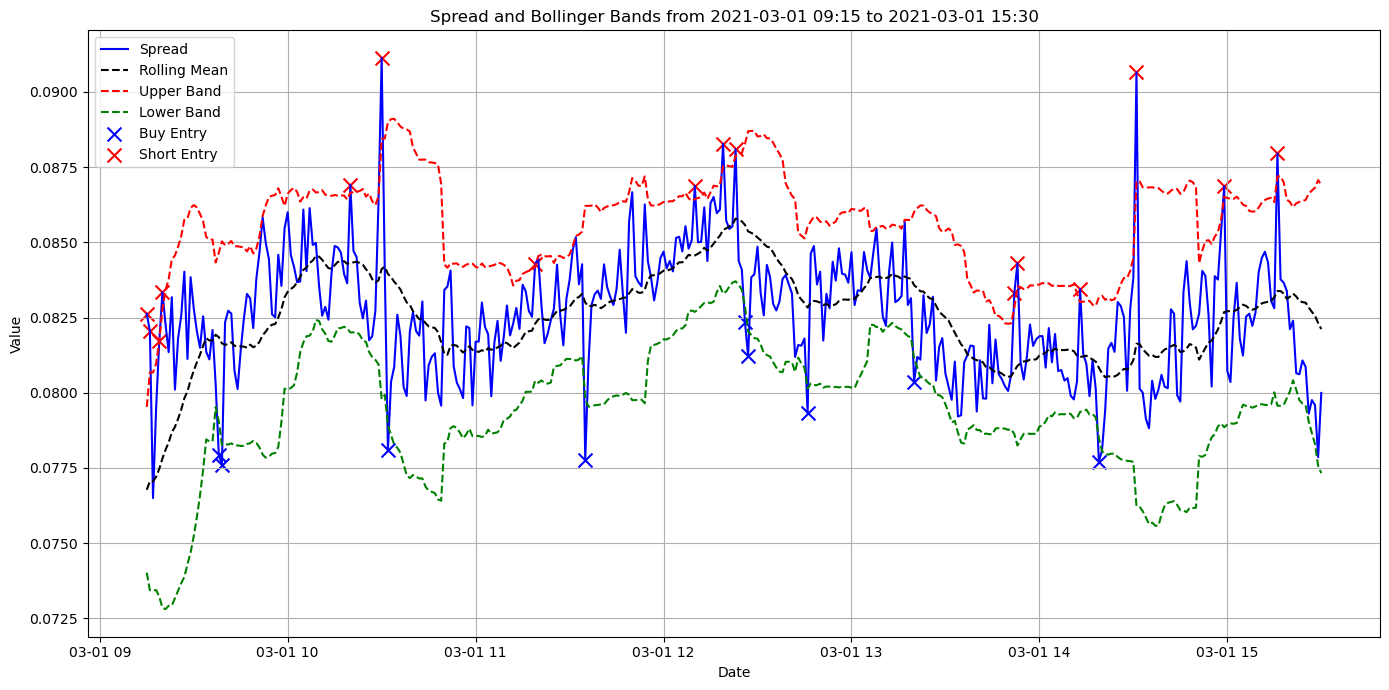

In [511]:
plot_bollinger_bands(df, '2021-03-01 09:15', '2021-03-01 15:30')

In [512]:
# We can see how the spread varies over 1 day, and how it generally moves out of these bands, and then back to the 
# mean. 

# One downside of this model is that it probably works better with high frequency trading as opposed to 
# medium frequency, since the graph shows that when it moves out of the Bollinger Bands, it usually moves quickly
# back in (sometimes before 30 minutes has passed).

In [513]:
# Question 2, a better model.

def bollinger_bands_trade_costs(BN, N, T):
    
    spread = BN - N
    window = 20                        # Window for rolling mean/std
    k = 2                              # How many standard deviations from the mean the bands will be, discussed 
                                       # later
    
    p_l = 0                            # Overall P/L
    spread_at_trade = 0                # Used in P/L Calculation
    number_of_longs = 0                # Tracks how many times we go long on the spread
    is_long = False                    # Tracks if we are long on the spread
    number_of_shorts = 0               # Tracks how many times we go short on the spread
    is_short = False                   # Tracks if we are short on the spread
    no_of_liquidations =0              # Tracks the number of times we liquidate
    trade_time = None                  # Records the time at which we go long/short
    minute_p_l = {}                    # Tracks minutely pnl
    
    middle_band = spread.rolling(window = window).mean()   # These are the Bollinger Bands for our data 
    std_dev = spread.rolling(window = window).std()
    upper_band = middle_band + (std_dev * k)
    lower_band = middle_band - (std_dev * k)
    
    for i in range(21,len(spread)):                        # Don't have data for first 20 minutes due to window
        current_datetime = spread.index[i]       
        current_time = current_datetime.time()   
        current_day = current_datetime.date()
        
        if current_day not in minute_p_l:
            minute_p_l[current_day] = 0
        
        # First Signal : If spread[i] > upper band : Short
        
        if spread[i] > upper_band[i] and not is_short and not is_long :   
            spread_at_trade = spread[i]   # Record what our spread is at this time
            number_of_shorts += 1         # We go short one time
            is_short = True               # Now we are short on the spread
            trade_time = spread.index[i]
                
       
        # Second Signal : If spread[i] < lower band : Long
        
        elif spread[i] < lower_band[i] and not is_long and not is_short :
            spread_at_trade = spread[i]  
            number_of_longs += 1
            is_long = True
            trade_time = spread.index[i]
        
                
        # Exit signals, if we cross the middle band from below when long or vice versa.
        
        if trade_time is not None:
            time_since_trade = current_datetime - trade_time  # Allows us to check how long our position is held
        
            if timedelta(minutes=30) <= time_since_trade < timedelta(days=5):  # Medium Frequency Trading
                
                if ((is_long and spread[i] >= middle_band[i]) or (is_short and spread[i] <= middle_band[i])) : 
                     
                    if is_long:
                        profit_loss = (spread[i] - spread_at_trade) * (T[i]**0.7)
                        p_l += 0.99 * (profit_loss)  # Calculate profit or loss based on exit condition
                        minute_p_l[current_day] += profit_loss
                    if is_short:
                        profit_loss = (spread_at_trade - spread[i]) * (T[i]**0.7)
                        p_l += 0.99 * (profit_loss)
                        minute_p_l[current_day] += profit_loss
                    
                    
                    is_long = False
                    is_short = False
                    no_of_liquidations += 1
                    trade_time = None             # Resets our variables so we can trade again
        
            
            # If we still have a position at T = 5 days from the trade, then liquidate
            if time_since_trade >= timedelta(days=5) and (is_long or is_short):
                if is_long:
                    profit_loss = (spread[i] - spread_at_trade) * (T[i]**0.7)
                    p_l = p_l + 0.99 * (profit_loss)
                    minute_p_l[current_day] += profit_loss
                if is_short:
                    profit_loss = (spread_at_trade - spread[i]) * (T[i]**0.7)
                    p_l = p_l + 0.99 *  (profit_loss)
                    minute_p_l[current_day] += profit_loss
                
                # Reset state
                is_long = False
                is_short = False
                no_of_liquidations += 1
                trade_time = None
                
    # Now convert minutely pnl to daily pnl using resampling
    
    df = pd.DataFrame(list(minute_p_l.items()), columns=['DateTime', 'PnL'])

    # Convert the 'DateTime' column to datetime type
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Set the 'DateTime' column as the index
    df.set_index('DateTime', inplace=True)

    # Resample to daily frequency and sum up the P&L for each day
    daily_pnl = df.resample('D').sum()

    # Convert to dictionary
    daily_p_l = daily_pnl['PnL'].to_dict()
                
    daily_returns = daily_pnl_to_returns(daily_p_l, 100)    # Creates daily returns again 
                
                
                    
    return [p_l, number_of_longs , number_of_shorts , no_of_liquidations , daily_returns]

In [514]:
bollinger_model = bollinger_bands_trade_costs(df['banknifty'], df['nifty'], df['tte'])

In [515]:
# Now for some analysis of the two models, we create the functions to calculate the Sharpe Ratio and Drawdown of a 
# portfolio

In [516]:
def calculate_sharpe_ratio(daily_returns):              # For simplicity, I assume a risk free rate of 0
    return daily_returns.mean() / daily_returns.std()

In [517]:
def calculate_max_drawdown(daily_returns):
    
    # Calculate the cumulative product as by the formula
    cumulative_returns = (1 + daily_returns).cumprod()
    # Calculate the running maximum
    running_max = cumulative_returns.cummax()
    # Calculate drawdowns
    drawdowns = (cumulative_returns - running_max) / running_max
    # Find the maximum drawdown
    max_drawdown = drawdowns.min()  # Drawdowns are negative, so the minimum is the largest in magnitude
    
    return -100*max_drawdown # Return as a positive percentage

In [518]:
# Now I will make a function to compare any two generic models. These take two arguments, which are 5-tuples
# and compares the P/L, Sharpe Ratio, Number of Trades and Drawdown.
# I decided to add in the 'number of trades' comparison as an extra way to compare and constrast the models 
# aside from general SR, P/L etc.

In [519]:
def compare_models(model1, model2):
    metrics = ['P/L', 'number of longs', 'number of shorts', 'number of liquidations']
    
    sharpe_ratio_model1 = calculate_sharpe_ratio(model1[-1])
    sharpe_ratio_model2 = calculate_sharpe_ratio(model2[-1])
    
    max_drawdown_model1 = calculate_max_drawdown(model1[-1])
    max_drawdown_model2 = calculate_max_drawdown(model2[-1])
    
    for i, metric in enumerate(metrics):
        model1_value = f"{model1[i]:.2f}" if metric == 'P/L' else model1[i]
        model2_value = f"{model2[i]:.2f}" if metric == 'P/L' else model2[i]
        
        if model1[i] < model2[i]:
            print(f"The {metric} of Model 1 is {model1_value}, versus {metric} of Model 2 is {model2_value}, so the {metric} of Model 2 is higher.")
            if metric == 'P/L':
                print("Having a higher P/L indicates that Model 2 is more profitable.")
            elif metric in ['number of longs', 'number of shorts']:
                print(f"A higher {metric} suggests that Model 2 engages in more frequent trading opportunities in this direction.")
            elif metric == 'number of liquidations':
                print("More liquidations might indicate more active trade management or more frequent signal changes in Model 2.")
        elif model1[i] > model2[i]:
            print(f"The {metric} of Model 1 is {model1_value}, versus {metric} of Model 2 is {model2_value}, so the {metric} of Model 1 is higher.")
            if metric == 'P/L':
                print("Having a higher P/L indicates that Model 1 is more profitable.")
            elif metric in ['number of longs', 'number of shorts']:
                print(f"A higher {metric} suggests that Model 1 engages in more frequent trading opportunities in this direction.")
            elif metric == 'number of liquidations':
                print("More liquidations might indicate more active trade management or more frequent signal changes in Model 1.")
        else:
            print(f"The {metric} is equal for both models, with a value of {model1_value}.")
        
        
    if sharpe_ratio_model1 != sharpe_ratio_model2:
        higher = "Model 1" if sharpe_ratio_model1 > sharpe_ratio_model2 else "Model 2"
        print(f"Sharpe Ratio of Model 1 is {sharpe_ratio_model1:.2f}, versus Sharpe Ratio of Model 2 is {sharpe_ratio_model2:.3f}.")
        print(f"Thus, the Sharpe Ratio of {higher} is higher, indicating a better risk-adjusted return.")
    else:
        print(f"Both models have an equal Sharpe Ratio of {sharpe_ratio_model1:.3f}.")
        
    print(f"Maximum Drawdown of Model 1 is {max_drawdown_model1}%, versus Maximum Drawdown of Model 2 is {max_drawdown_model2}%.")
    if max_drawdown_model1 != max_drawdown_model2:
        # For drawdown, a lower (less negative or more positive) number is better
        better = "Model 1" if max_drawdown_model1 < max_drawdown_model2 else "Model 2"
        print(f"Thus, {better} has a lower Maximum Drawdown, indicating better risk management.")

In [520]:
compare_models(z_score_model, bollinger_model)

The P/L of Model 1 is 54.14, versus P/L of Model 2 is 73.49, so the P/L of Model 2 is higher.
Having a higher P/L indicates that Model 2 is more profitable.
The number of longs of Model 1 is 1376, versus number of longs of Model 2 is 1240, so the number of longs of Model 1 is higher.
A higher number of longs suggests that Model 1 engages in more frequent trading opportunities in this direction.
The number of shorts of Model 1 is 1312, versus number of shorts of Model 2 is 1193, so the number of shorts of Model 1 is higher.
A higher number of shorts suggests that Model 1 engages in more frequent trading opportunities in this direction.
The number of liquidations of Model 1 is 2688, versus number of liquidations of Model 2 is 2432, so the number of liquidations of Model 1 is higher.
More liquidations might indicate more active trade management or more frequent signal changes in Model 1.
Sharpe Ratio of Model 1 is 0.34, versus Sharpe Ratio of Model 2 is 0.388.
Thus, the Sharpe Ratio of Mo

In [521]:
# Assumptions made throughout the assignment:

# Firstly, on dealing with the data:
# I filtered the data between the trading hours of 09:15 and 15:30 as per the requirement of the assignment.
# Next, I used the 'fillna' method to identify where there are NA values and fill them with the same value as the 
# row before. Generally, since the time series is minutely, this seems like a good approach and when I compared it 
# to dropping the NA values all together, it gave very similar values for the P/L, number of trades, etc, whilst 
# maintaing the completeness of the data.

# Secondly, I have assumed that there are 365 trading days in a year. This means we can trade on all days including
# weekends as long as we are in the hours between 09:15 and 15:30. This was to avoid going back to 2021 and 
# noting when every bank holiday was.

# An assumption for pairs trading to work is that the two indexes' volatilities are highly correlated.
# Since this was stated as the assumption before the assignment, I have assumed it as true and to visualise it, 
# plotted graphs throughout, that generally show good signs that they are correlated. If we wanted to analyse this
# further, we could use tests such as Pearson correlation, Spearman etc.

# Next, in my models I assumed a small transaction fee to make it more realistic. This was present when calculating
# p/l in the 0.99 factor, since the second model was making a lot more trades, and I didn't want it to be a simple 
# case of more trades = more money so I added this in.

# Parameter selection: 

# For Model 1 (Z-Score), the entry points for trades were Z-Scores of 1.75 and -1.75. Generally, Z-Score entry 
# values can range from 1.5 to 2.5 with 1.5 being a more aggresive strategy and 2.5 more conservative. This is
# because, the spread having a Z-Score of  > 1.75 for example, represents that spread value being more than 1.75
# standard deviations from its mean. This suggests that the observed deviation from the mean is less likely due to
# random chance and hence provides a rigorous point for us to long or short the spread. 
# I used the value 1.75 because I wanted a slightly more aggressive strategy than a value of 2 would provide, and 
# I used exit points of 0.75 to try to capture the profits before it deviated all the way back to its mean, which
# is more fitting with the medium frequency trading strategy.

# The reasoning for the use of k = 2 in the Bollinger Bands model was very similar. However I wanted this strategy
# to be slightly more conservative, and after researching about Bollinger Bands models, this value of 2 is a very
# common parameter choice. 

# To further delve into this, we could conduct parameter optimzation on these values with market data to obtain
# the optimal Z-Scores to use to maximise profits on these particular indexes.

# Finally, I assumed that the general 'Medium Frequency Trading' limits given to me were strict. For example True 
# Beacon would not want any positions held longer than 5 days strictly, and so if we got to T = 5 days and we were
# still long or short, I would sell/buy at that minute, regardless of the spread. The same goes for only liquidating
# positions more than 30 minutes after making that trade.


In [522]:
# Summary and Findings

# As stated in the comparison function, Model 2 outperforms Model 1 everywhere.
# It has a ~36% higher P/L and a ~14% higher Sharpe Ratio.

# Both models however, have a low Sharpe Ratio overall. A Sharpe Ratio below 1 is sub-optimal, and so this is a 
# downside of the models. To improve this, further analysis and research would need to be done on the correlation
# and most optimal times to trade.

# The Drawdown of both strategies are very low, indicating they do not carry a lot of risk, which is an advantage 
# of the algorithms. The Drawdown of model 2 is slightly lower which is an attractive feature of the strategy.

# Both models make a similar number of trades (around 2500 for 1 year and a half), which seems like a realistic 
# number. However as I mentioned earlier, with this data it is likely that model 2 would actually perform better in
# a high frequency system. 

# Overall, both models provide insight into how we can take advantage of two indexes, stocks, (or even assets 
# across different classes, such as a currency and oil product) being correlated and make money on the spread of 
# them. I chose the Bollinger Bands idea because it is used to identify opportunities where the spead is 
# 'overbought' or 'oversold' and hence provides a simple yet effective way to make a profit based on this thesis.